In [14]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from tqdm import tqdm
import shutil
from utils import count_parameters, accuracy, pooling
from config import NUM_EPOCHS, CV_DATA

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam, ClippedAdam, SGD

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
plt.style.use('ggplot')

In [46]:
df = pd.read_csv(CV_DATA, delimiter='\t', header=None)
df.rename({0: 'y'}, axis=1, inplace=True)
y = df['y']-1
df.drop('y', axis=1, inplace=True)

In [6]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
0,-0.569701,-0.567901,-0.565901,-0.563701,-0.561501,-0.559101,-0.556701,-0.554101,-0.551501,-0.548701,...,-0.518401,-0.521501,-0.525101,-0.529001,-0.533201,-0.537901,-0.543001,-0.548501,-0.554501,-0.560801
1,-0.528303,-0.520903,-0.512903,-0.504303,-0.494903,-0.485003,-0.474403,-0.463203,-0.451303,-0.438903,...,-0.673504,-0.670104,-0.664604,-0.656704,-0.646504,-0.633804,-0.618604,-0.600603,-0.579903,-0.556303
2,0.164201,0.181901,0.198601,0.214301,0.229001,0.242701,0.255501,0.267401,0.278401,0.288601,...,0.233501,0.225401,0.217301,0.209201,0.201101,0.193101,0.185201,0.177301,0.169401,0.161701
3,0.321800,0.327001,0.332401,0.337901,0.343501,0.349201,0.355001,0.360801,0.366701,0.372701,...,0.262200,0.268300,0.274400,0.280500,0.286600,0.292600,0.298600,0.304600,0.310500,0.316400
4,-0.461699,-0.464499,-0.466499,-0.467499,-0.467699,-0.467099,-0.465699,-0.463499,-0.460599,-0.457099,...,-0.465999,-0.465899,-0.466399,-0.467399,-0.468999,-0.471099,-0.473799,-0.477099,-0.480999,-0.485499


### Model

In [7]:
from bayesian_nn import *

In [8]:
state = torch.load('nn_state.pth.tar')

In [9]:
mdl = Classifier()

In [10]:
mdl.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [11]:
def predict(x, num_samples=10):
    sampled_models = [mdl.guide(None, None) for _ in range(num_samples)]
    yhats = [model(x.to(device)).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return mean.argmax(dim=1)

In [17]:
x = df.iloc[0].values.reshape(1,-1)
x = pooling(x, (1,8))
x = torch.FloatTensor(x)

In [20]:
predict(x)

tensor([1])

### Calculate certainties 

In [21]:
def sample_preds(x, num_samples=10):
    sampled_models = [mdl.guide(None, None) for _ in range(num_samples)]
    logits = [F.log_softmax(model(x.to(device)).data, dim=1) for model in sampled_models]
    preds = [a.argmax(dim=1) for a in logits]
    res = torch.stack(logits)
    u = res.mean(0)
    std = res.std(0)
    return logits, preds, u, std

In [22]:
sample_preds(x)

([tensor([[-8.3446e-07, -1.4008e+01, -2.1562e+01]]),
  tensor([[-23.1565, -38.6258,   0.0000]]),
  tensor([[ -0.0160, -13.8139,  -4.1439]]),
  tensor([[-3.1544e+01, -1.4634e+01, -4.7684e-07]]),
  tensor([[-1.9669e-05, -1.0838e+01, -1.8073e+01]]),
  tensor([[-26.3040, -18.8223,   0.0000]]),
  tensor([[-0.0393, -3.6399, -4.3958]]),
  tensor([[-8.4033e-03, -9.5115e+00, -4.7922e+00]]),
  tensor([[ -0.0727,  -2.6577, -41.6010]]),
  tensor([[-8.9881, -0.1143, -2.2269]])],
 [tensor([0]),
  tensor([2]),
  tensor([0]),
  tensor([2]),
  tensor([0]),
  tensor([2]),
  tensor([0]),
  tensor([0]),
  tensor([0]),
  tensor([1])],
 tensor([[ -9.0130, -12.6665,  -9.6795]]),
 tensor([[12.8739, 10.9101, 13.5388]]))

In [26]:
def summary(ts, num_samples=100):
#     ts = ts.reshape(1,-1)
#     ts = pooling(ts, (1,8))
    x = torch.FloatTensor(ts).unsqueeze(0)
    _, preds, u, std = sample_preds(x, num_samples=num_samples)
    preds = np.array(preds)
    u = u.detach().numpy()
    std = std.detach().numpy()
    out = {'preds': preds, 'u': u, 'std': std}
    return out

In [27]:
# num_samples=10
# d = {}
# for i, ts in tqdm(enumerate(df.values)):
#     x = torch.FloatTensor(ts).unsqueeze(0)
#     _, preds, u, std = sample_preds(x, num_samples=num_samples)
#     preds = np.array(preds)
#     u = u.detach().numpy()
#     std = std.detach().numpy()
#     d[i] = {'preds': preds, 'u': u, 'std': std}

In [57]:
idx = 514

In [60]:
y[idx]

1

In [84]:
out = summary(df.values[idx], num_samples=100)

In [85]:
out

{'preds': array([1, 0, 0, 2, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 0, 0, 0,
        0, 0, 0, 2, 0, 2, 1, 0, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 0, 2, 2,
        2, 2, 2, 1, 1, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1,
        0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2,
        1, 1, 2, 0, 1, 0, 1, 2, 2, 2, 1, 2]),
 'u': array([[-14.313608, -13.238234, -17.056038]], dtype=float32),
 'std': array([[18.138685, 15.337047, 23.085642]], dtype=float32)}

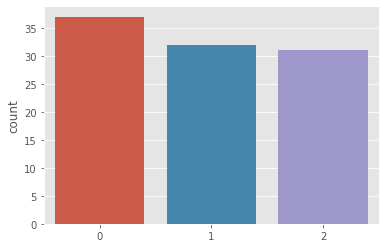

In [86]:
sns.countplot(out['preds'])

In [90]:
from collections import Counter

In [91]:
Counter(list(out['preds']))

Counter({1: 32, 0: 37, 2: 31})

In [89]:
out['u'].argmax(1)

array([1])

### Subset 

In [75]:
ixs = np.arange(100)

In [78]:
inputs = df.iloc[ixs].values
inputs = pooling(inputs, (1,8))

In [80]:
inputs.shape

(100, 128)

In [82]:
for ts in tqdm(inputs):
    

(128,)

### Plot series 

In [ ]:
def plot_ts(ts):
    y = ts.values
    x = np.arange(0, len(y), 1)
    plt.figure(figsize=(7,5))
    sns.lineplot(x, y)
    plt.show()

In [ ]:
plot_ts(df.iloc[500])

In [ ]:
def plt_multiple(ixs):
    fig, ax = plt.subplots(nrows=2, sharey=True, sharex=True)
    for i, ix in enumerate(ixs):
        y = df.iloc[ix]
        x = np.arange(0, len(y), 1)
        sns.lineplot(x,y, ax=ax[i])

In [ ]:
plt_multiple([4, 5])